## We'll be analyzing the BDT response under different elliptical angular cuts of base tracks
First let's load the necessary imports

In [60]:
import sys
import pandas as pd
import matplotlib.pyplot as plt
import fedra2scipy_utils
import numpy as np
import uproot
import math
import awkward as ak
import matplotlib as mpl
mpl.rc('xtick', labelsize=14) 
mpl.rc('ytick', labelsize=14) 

Load the vertex files of Run 1 data with BDT response. This data is from a single cell: (8, 13). 3 different cuts of size 0.2 $\sigma$, 0.4 $\sigma$, and 0.6 $\sigma$ from the mean are applied. These correspond to elliptical areas of 4.0e-05, 1.6e-04, and 3.6e-04 rad$^2$ cut out of the plane of XZ v. YZ base track angles around the distribution peak. By omitting shallow angled tracks we hope to improve the signal-to-background ratio.

Note that standard deviation is computed with respect to the angular distribution of base track angles within 0.05 rad of the peak.

In [10]:
d_prepath = '/eos/user/t/tkrishna/data_vtxfiles/vertex_TMVA_ell_'
d_nocut_path = '/eos/user/t/tkrishna/data_vtxfiles/vertex_TMVA.root'

df_list = []

fname_list = ['2', '4', '6']
anglecut_list_sim = [2, 4, 6]
branchnames = ['vID', 'vz', 'ntrks', 'sTX', 'sTY', 'sPID', 'nseg', 'npl', 'sID', 'BDT']
# add original file (nocut) to df list
sim_file = uproot.open(d_nocut_path)
sim_tree = sim_file['vtx']
df = sim_tree.arrays(branchnames, library='pd')
df['brickID'] = 11
df_list += [df]
# add cut files to df list
for i in range(len(fname_list)):
    sim_file = uproot.open(d_prepath + fname_list[i] + '.root')
    sim_tree = sim_file['vtx']
    df = sim_tree.arrays(branchnames, library='pd')
    df['brickID'] = 44
    df_list += [df]

Let's first look at the overall shape of the BDT response for the different cuts, shown below

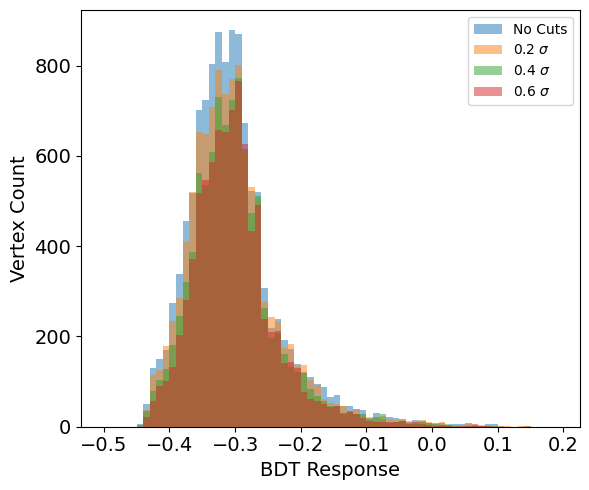

In [37]:
fig, ax = plt.subplots(figsize=(6, 5), tight_layout=True)
bins_ = np.arange(-0.5, 0.2, 0.01)
a=0.5
for i in range(len(df_list)):
    if i==0: 
        label = "No Cuts"
    else:
        label = "0."+fname_list[i-1]+r" $\sigma$"
    ax.hist(df_list[i]['BDT'], bins=bins_, alpha=a, label=label)
ax.set_xlabel("BDT Response", fontsize=14)
ax.set_ylabel("Vertex Count", fontsize=14)
plt.legend()
    
plt.show()

## BDT Cuts

Now let's cut at BDT response -0.0622. This should give signal efficiency = 92.48% and background rejection = 97.43% (see Fabio's work for more details)

In [38]:
bdt_cutoff = -0.0622
background = []
signal = []
for df in df_list:
    background_df = df[df['BDT'] < bdt_cutoff]
    signal_df = df[df['BDT'] >= bdt_cutoff]
    background += [background_df]
    signal += [signal_df]

### Signal v. Background: Vertex Reconstruction

For each of the cuts, let's first look at vertices. What proportion of background survives and what proportion of signal survives?

In [56]:
print("No Cut")
print("Signal Vertices: ", len(signal[0]))
print("Background Vertices: ", len(background[0]))
print()

for i in range(len(df_list[1:])):
    print("0."+str(fname_list[i])+"σ Cut")
    print("Signal Vertices: ", len(signal[i+1]), "which is", str(round(len(signal[i+1])/len(signal[0])*100, 2))+ "% of no cut")
    print("Background Vertices: ", len(background[i+1]), "which is", str(round(len(background[i+1])/len(background[0])*100, 2))+"% of no cut")
    print()


No Cut
Signal Vertices:  140
Background Vertices:  11534

0.2σ Cut
Signal Vertices:  128 which is 91.43% of no cut
Background Vertices:  10625 which is 92.12% of no cut

0.4σ Cut
Signal Vertices:  86 which is 61.43% of no cut
Background Vertices:  9384 which is 81.36% of no cut

0.6σ Cut
Signal Vertices:  70 which is 50.0% of no cut
Background Vertices:  8801 which is 76.3% of no cut



It is easier to see in a plot, the proportion of vertices remaining (as compared to no cut) as a function of the effective radius of the cut. Effective radius is the radius of the circle with the same enclosed area as the fitted ellipse.

In [75]:
anglecut_list_data = np.asarray([1.0082142660517188e-05, 4.032857064206875e-05, 9.073928394465467e-05]) # area of ellipses
anglecut_list_data = np.sqrt(anglecut_list_data/math.pi) # effective radius of ellipses


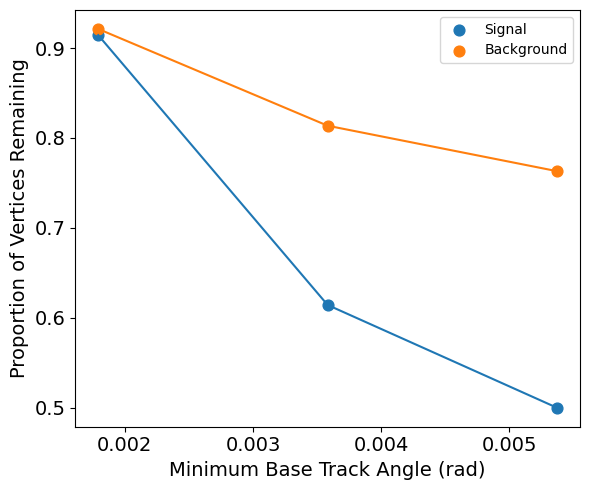

In [77]:
fig, ax = plt.subplots(1, figsize=(6, 5), tight_layout=True)
for i in range(len(anglecut_list_sim)):
    dot1 = ax.scatter(anglecut_list_data[i], len(signal[i+1])/len(signal[0]), s=60, color='tab:blue')
    dot2 = ax.scatter(anglecut_list_data[i], len(background[i+1])/len(background[0]), s=60, color='tab:orange')
ax.plot(anglecut_list_data, [len(signal[i+1])/len(signal[0]) for i in range(0, len(anglecut_list_data))], color='tab:blue')
ax.plot(anglecut_list_data, [len(background[i+1])/len(background[0]) for i in range(0, len(anglecut_list_data))], color='tab:orange')

ax.legend([dot1, dot2], ['Signal', 'Background'])
ax.set_xlabel("Minimum Base Track Angle (rad)", fontsize=14)
ax.set_ylabel("Proportion of Vertices Remaining", fontsize=14)
ax.set_xticks(np.arange(0.002, 0.006, 0.001))
plt.savefig("Figures/AngleCuts/vtxFrac_scatter_smallAngle_goodVtx_dataBDT.pdf")
plt.show()

### Signal v. Background: Segment Reconstruction

Now let's look at segments. First we'll flatten each of the vertex lists to get the number of segments and go from there.

In [63]:
signal_segs = [np.asarray(ak.flatten(sig['sTX'])) for sig in signal]
bkg_segs = [np.asarray(ak.flatten(bkg['sTX'])) for bkg in background]

In [64]:
print("No Cut")
print("Signal Segments: ", len(signal_segs[0]))
print("Background Segments: ", len(bkg_segs[0]))
print()

for i in range(len(df_list[1:])):
    print("0."+str(fname_list[i])+"σ Cut")
    print("Signal Segments: ", len(signal_segs[i+1]), "which is", str(round(len(signal_segs[i+1])/len(signal_segs[0])*100, 2))+ "% of no cut")
    print("Background Segments: ", len(bkg_segs[i+1]), "which is", str(round(len(bkg_segs[i+1])/len(bkg_segs[0])*100, 2))+"% of no cut")
    print()


No Cut
Signal Segments:  7279
Background Segments:  551233

0.2σ Cut
Signal Segments:  7023 which is 96.48% of no cut
Background Segments:  495869 which is 89.96% of no cut

0.4σ Cut
Signal Segments:  4473 which is 61.45% of no cut
Background Segments:  414168 which is 75.13% of no cut

0.6σ Cut
Signal Segments:  4049 which is 55.63% of no cut
Background Segments:  367817 which is 66.73% of no cut



It is easier to see in a plot, the proportion of segments remaining (as compared to no cut) as a function of the effective radius of the cut. Effective radius defined the same as before. We also count the segments by the sTX values, as there is one value for each segment in a given vertex.

In [73]:
nums = [len(ak.flatten(signal[i]['sTX'])) for i in range(len(signal))]
numb = [len(ak.flatten(background[i]['sTX'])) for i in range(len(background))]

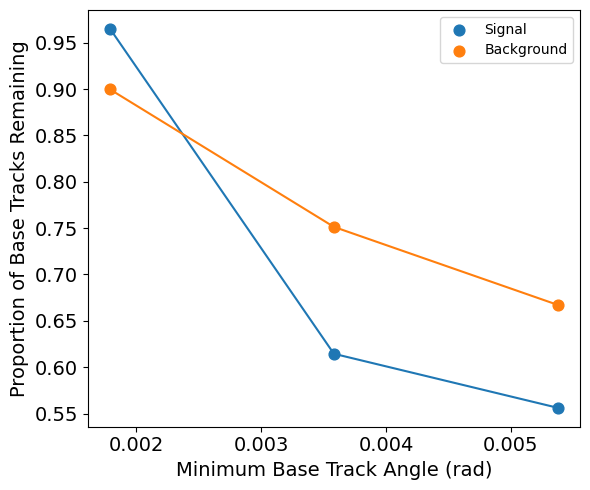

In [78]:
fig, ax = plt.subplots(1, figsize=(6, 5), tight_layout=True)
for i in range(len(anglecut_list_sim)):
    dot1 = ax.scatter(anglecut_list_data[i], nums[i+1]/nums[0], s=60, color='tab:blue')
    dot2 = ax.scatter(anglecut_list_data[i], numb[i+1]/numb[0], s=60, color='tab:orange')
ax.plot(anglecut_list_data, [nums[i+1]/nums[0] for i in range(0, len(anglecut_list_data))], color='tab:blue')
ax.plot(anglecut_list_data, [numb[i+1]/numb[0] for i in range(0, len(anglecut_list_data))], color='tab:orange')

ax.legend([dot1, dot2], ['Signal', 'Background'])
ax.set_xlabel("Minimum Base Track Angle (rad)", fontsize=14)
ax.set_ylabel("Proportion of Base Tracks Remaining", fontsize=14)
ax.set_xticks(np.arange(0.002, 0.006, 0.001))
plt.savefig("Figures/AngleCuts/segFrac_scatter_smallAngle_goodVtx_dataBDT.pdf")
plt.show()